# Dog Breed Classifier

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.

In this project, we train and deploy a model that classifies dog breeds. 

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [149]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [103]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
from sagemaker.tuner import ContinuousParameter, CategoricalParameter, IntegerParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import IPython

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

from PIL import Image
import io

import numpy as np

## Dataset
The Dog Breeds Dataset includes images of varying sizes from 133 different types of dog breeds. The dataset is divided into train, validation and test folders. 

In [12]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip


--2021-12-12 18:39:46--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.0
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  40.4MB/s    in 26s     

2021-12-12 18:40:21 (42.0 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affe

In [120]:
sess = sagemaker.Session()
bucket = sess.default_bucket()  

os.environ["DEFAULT_S3_BUCKET"] = bucket

!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

## Hyperparameter Tuning

Here I'm tuning the following paramters: learning rate (lr), batch size, and epoch. I chose these hyperparameters since they typically have the biggest effect on a model's performance.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [121]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges={
    "lr":ContinuousParameter(0.001, 0.1),
    "batch_size":CategoricalParameter([16,32,64,128]),
    "epochs": IntegerParameter(2, 5)
}

In [122]:
session = sagemaker.Session()
bucket = session.default_bucket()
region =session.boto_region_name
role = get_execution_role()

In [123]:
os.environ['SM_MODEL_DIR'] = 's3://'+bucket+'/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = 's3://'+bucket+'/output/'

In [126]:

#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point='hpo.py',
    py_version='py36',
    base_job_name='hpo_tuning',
    role=role,
    framework_version='1.8',
    instance_count=1,
    instance_type='ml.m5.large')

#estimator.fit({'train': 's3://sagemaker-us-east-1-847017168036/train', 'valid':'s3://sagemaker-us-east-1-847017168036/valid',
#                       'test': 's3://sagemaker-us-east-1-847017168036/test'})


objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

#objective_metric_name="Accuracy"
#objective_type="Maximize"
#metric_definitions = [{"Name": "Accuracy", "Regex": "Test Accuracy: ([0-9\\.]+)"}]
#os.environ['SM_MODEL_DIR'] = 's3://sagemaker-us-east-1-847017168036/dogImages/model/'
#os.environ['SM_OUTPUT_DATA_DIR'] = 's3://sagemaker-us-east-1-847017168036/dogImages/output/'

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type='Auto')

s3_data = "s3://{}/{}/".format(bucket, "dogImages")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAIN']= s3_data
os.environ['SM_MODEL_DIR']= s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir

tuner.fit({'train' : s3_data},wait=True) 

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [130]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-28 11:46:52 Starting - Preparing the instances for training
2021-12-28 11:46:52 Downloading - Downloading input data
2021-12-28 11:46:52 Training - Training image download completed. Training in progress.
2021-12-28 11:46:52 Uploading - Uploading generated training model
2021-12-28 11:46:52 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"32"',
 'epochs': '3',
 'lr': '0.005010591629383133',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo_tuning-2021-12-28-11-13-30-152"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-847017168036/hpo_tuning-2021-12-28-11-13-30-152/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [131]:
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

In [134]:
hyperparameters = {"batch_size": "32", "epochs":"3", "lr": "0.005010591629383133"}

estimator_train = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

estimator_train.fit({'train' : s3_data},wait=True)

2021-12-28 20:09:48 Starting - Starting the training job...
2021-12-28 20:10:15 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2021-12-28 20:11:15 Starting - Preparing the instances for training.........
2021-12-28 20:12:44 Downloading - Downloading input data............
2021-12-28 20:14:44 Training - Downloading the training image...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-28 20:16:30,975 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-28 20:16:30,997 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-28 20:16:34,043 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-12-28 2

In [135]:
training_job_name = estimator_train.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator_train.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator_train.output_path + estimator_train.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator_train.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

Training jobname: pytorch-training-2021-12-28-20-09-48-131
Region: us-east-1
[2021-12-28 20:24:13.226 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-847017168036/pytorch-training-2021-12-28-20-09-48-131/debug-output
[2021-12-28 20:24:13.570 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 2009 more expected)', IncompleteRead(0 bytes read, 2009 more expected)) while reading s3://sagemaker-us-east-1-847017168036/pytorch-training-2021-12-28-20-09-48-131/debug-output/index/000000000/000000000110_worker_0.json . Will retry now
[2021-12-28 20:24:15.745 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-28 20:24:16.777 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:

You will find the profiler report in s3://sagemaker-us-east-1-847017168036/pytorch-training-2021-12-28-20-09-48-131/rule-output
2021-12-28 20:22:20     423270 pytorch-training-2021-12-28-20-09-48-131/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-28 20:22:19     279709 pytorch-training-2021-12-28-20-09-48-131/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-28 20:22:14        567 pytorch-training-2021-12-28-20-09-48-131/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-28 20:22:14      24219 pytorch-training-2021-12-28-20-09-48-131/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-28 20:22:15       1879 pytorch-training-2021-12-28-20-09-48-131/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-28 20:22:14        130 pytorch-training-2021-12-28-20-09-48-131/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.jso

In [137]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [139]:
tensor_name = "CrossEntropyLoss_output_0"
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250,
  260,
  270,
  280,
  290,
  300,
  310,
  320,
  330,
  340,
  350,
  360,
  370,
  380,
  390,
  400,
  410,
  420,
  430,
  440,
  450,
  460,
  470,
  480,
  490,
  500,
  510,
  520,
  530,
  540,
  550,
  560,
  570,
  580,
  590,
  600,
  610,
  620],
 [array(4.9436755, dtype=float32),
  array(4.8570914, dtype=float32),
  array(4.4732375, dtype=float32),
  array(4.269347, dtype=float32),
  array(3.687453, dtype=float32),
  array(3.409482, dtype=float32),
  array(3.2208056, dtype=float32),
  array(2.1426072, dtype=float32),
  array(2.2916746, dtype=float32),
  array(1.8348656, dtype=float32),
  array(1.9679728, dtype=float32),
  array(1.5898726, dtype=float32),
  array(1.7446977, dtype=float32),
  array(1.2823666, dtype=float32),
  array(1.6967571, dtype=float32),
  array(1.4263989, dtype=float32),
  array(1.34

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


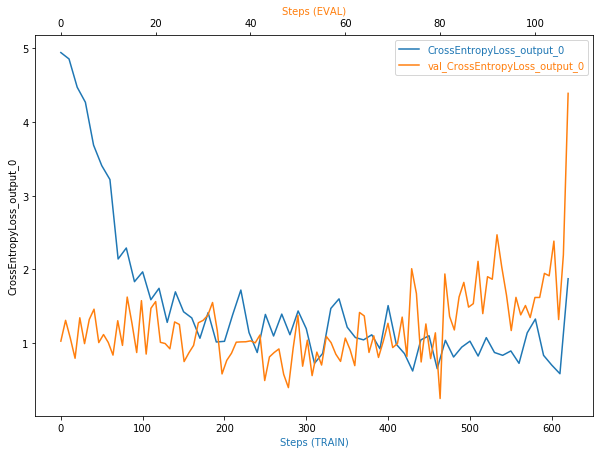

In [140]:
plot_tensor(trial, "CrossEntropyLoss_output_0") #Plotting the loss

There were no anomolies in this report, but if there were, I would carefully go through the details and follow the recommendation listed on the report.

In [ ]:
# TODO: Display the profiler output

## Model Deploying

In [141]:
estimator_train.model_data

's3://sagemaker-us-east-1-847017168036/pytorch-training-2021-12-28-20-09-48-131/output/model.tar.gz'

In [142]:
# TODO: Deploy your model to an endpoint
model_location=estimator_train.model_data

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

In [143]:

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [156]:

pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='endpoint.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor) 

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type="ml.g4dn.xlarge") 


-----------!

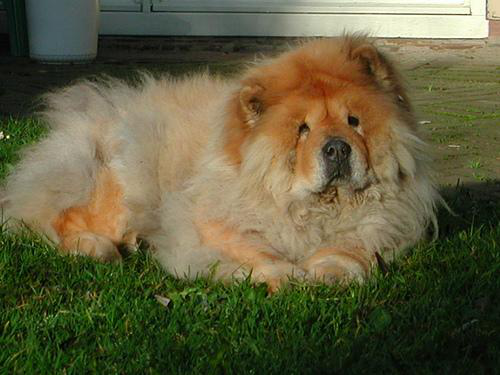

In [151]:
with open("./dogImages/test/051.Chow_chow/Chow_chow_03591.jpg", "rb") as f: 
    payload = f.read()
    
Image.open(io.BytesIO(payload))
    

In [161]:
response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response



[[-10.435847282409668,
  -9.223681449890137,
  -24.292396545410156,
  -1.582310676574707,
  -18.013093948364258,
  -14.71384334564209,
  -28.283321380615234,
  -16.173799514770508,
  -15.467745780944824,
  -21.003429412841797,
  -25.644996643066406,
  -19.117860794067383,
  -19.16317367553711,
  -26.09825325012207,
  -23.900318145751953,
  -22.862518310546875,
  -16.36368179321289,
  -29.365440368652344,
  -25.34149169921875,
  -27.354318618774414,
  -21.33869171142578,
  -13.860469818115234,
  -19.80038833618164,
  -13.446233749389648,
  -27.671886444091797,
  -19.61946678161621,
  -20.293899536132812,
  -40.21018981933594,
  -19.303905487060547,
  -15.907869338989258,
  -22.15923309326172,
  -37.20414352416992,
  -10.989802360534668,
  -16.980640411376953,
  -21.745159149169922,
  -11.309940338134766,
  -28.242162704467773,
  -8.891868591308594,
  -29.199228286743164,
  -14.110269546508789,
  -21.367630004882812,
  -13.065240859985352,
  -18.018678665161133,
  -20.101558685302734,
  

In [162]:
#This comes out class 50, which is the Chinese shar-pei, which looks similar to the Chow Chow
np.argmax(response, 1)

array([50])

In [163]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()